# BERT base neuralmind, soma dos score do par.

## Conceptnet-hypernym-1
- (1,1) é um par onde hipônimo e hiperônimo são de tamanho 1
- O tamanho do par (1,1) será 2, assim como o tamanho do par (2,1) e (1,2) será 3

> Suponha o par (3,2) (abacate, fruta)
> Temos as seguintes sentenças:
- [MASK] ca te é um tipo de fru ta
- aba [MASK] te é um tipo de fru ta
- aba ca [MASK] é um tipo de fru ta
- aba ca te é um tipo de [MASK] ta
- aba ca te é um tipo de fru [MASK]

> Mascarando a palavra e pegando o score dela. O score pra esse par será a soma de todos os valores recuperados.


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

sns.set(style="whitegrid")
plt.clf()
# data
f_in = open("../aaaaaaaa/test_neuralmind-bert-base-portuguese-cased/TESTE.json")
# f_in = open("../teste/neuralmind-bert-base-portuguese-cased_bert-score_n-subtoken/conceptnet-hypernym-1.json")
json_data = json.load(f_in)

def create_dataframe(json_dict):
    dict_values = {'hiponimo': [], 'hiperonimo':[], 'classe':[], 'fonte':[], 'pattern': [], 'soma_hipo':[], 'soma_hiper':[], 'len_hipo':[], 'len_hiper':[]}
    for data, values in json_data.items():
        hipo, hiper, classe, fonte = data.strip().split()
        for pattern, score in values.items():
            dict_values['hiponimo'].append(hipo)
            dict_values['hiperonimo'].append(hiper)
            dict_values['classe'].append(classe)
            dict_values['fonte'].append(fonte)
            dict_values['pattern'].append(pattern)
            soma = sum(score[0])
            dict_values['soma_hipo'].append(soma)
            soma = sum(score[1])
            dict_values['soma_hiper'].append(soma)
            dict_values['len_hipo'].append(len(score[0]))
            dict_values['len_hiper'].append(len(score[1]))
    return dict_values

dict_values = create_dataframe(json_data)

df = pd.DataFrame(dict_values)
del dict_values
df['bert_soma_total'] = df['soma_hipo'] + df['soma_hiper']
df['len_total'] = df['len_hipo'] + df['len_hiper']
pattern_unique = df['pattern'].unique().tolist()
len_total_unique = df['len_total'].unique().tolist()

# verificar balanceamento True/False
df_rate = df[df['pattern'] == pattern_unique[0]][['hiponimo', 'hiperonimo', 'classe', 'fonte', 'len_total']]
df_rate = df_rate.groupby(['len_total'])['classe'].value_counts()
dict_values = {'len_total': [], 'true':[], 'false':[], 'ratio':[]}
for v in len_total_unique:
    dict_values['len_total'].append(v)
    if "True" in df_rate[v]:
        dict_values['true'].append(df_rate[v]['True'])
    else:
        dict_values['true'].append(0)
    if "False" in df_rate[v]:
        dict_values['false'].append(df_rate[v]['False'])
    else:
        dict_values['false'].append(0)

    dict_values['ratio'].append(dict_values['true'][-1] / (dict_values['true'][-1] + dict_values['false'][-1]))
df_taxa = pd.DataFrame(dict_values)
del dict_values

#logsumexp para cada tamanho subtoken
log_store = {}
logsumexp_store = {}
normalization = {}
for size in len_total_unique:
    log_store[size] = {}
    logsumexp_store[size] = {}
    normalization[size] = {}
    for p in pattern_unique:
        if p in log_store:
            raise ValueError
        values = df[(df.pattern == p) & (df.len_total == size)]
        log_store[size][p] = torch.tensor(values['bert_soma_total'].tolist())
        logsumexp_store[size][p] = torch.logsumexp(log_store[size][p], dim=0)
        normalization[size][p] = torch.sum(log_store[size][p])

df['log(Z)'] = df.apply(lambda row: logsumexp_store[row['len_total']][row['pattern']].item(), axis=1)
df['sum_bert_by_tokensize'] = df.apply(lambda row: normalization[row['len_total']][row['pattern']].item(), axis=1)

<Figure size 432x288 with 0 Axes>

### Razão entra True/False
- eixo X = tamanho do subtokem do par
- eixo Y = porcentagem dos pares True

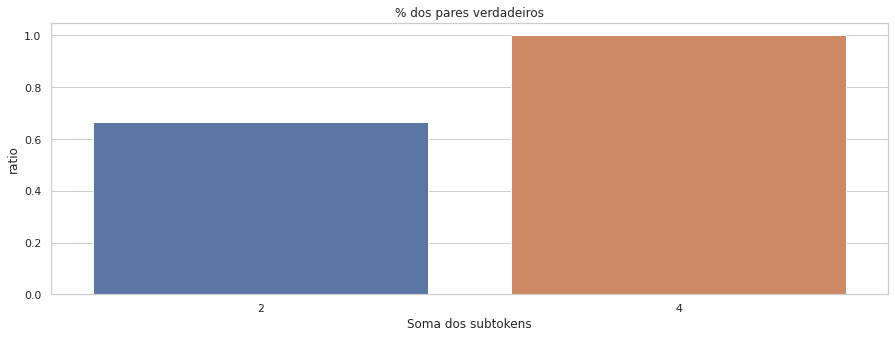

In [2]:
# figure
plt.figure(figsize=(15,5))
ax = sns.barplot(x='len_total', y='ratio', data=df_taxa)
ax.set(xlabel="Soma dos subtokens")
ax.set_title(f"% dos pares verdadeiros")
plt.show()


### log(Z) score para cada tamanho de subtoken e padrão.
- eixo X = Tamanho do subtoken
- eixo Y = log(Z)

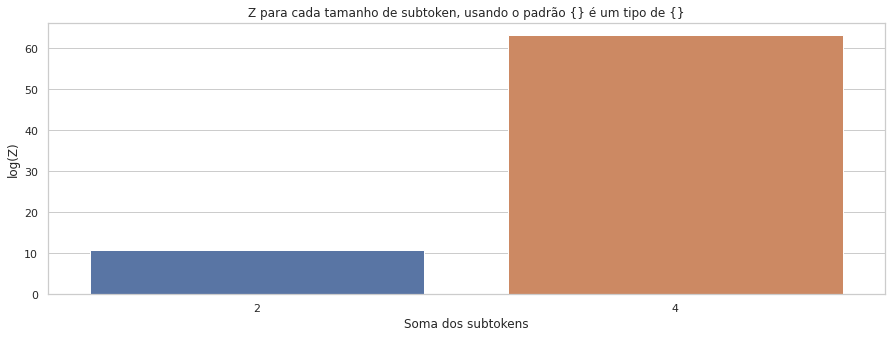

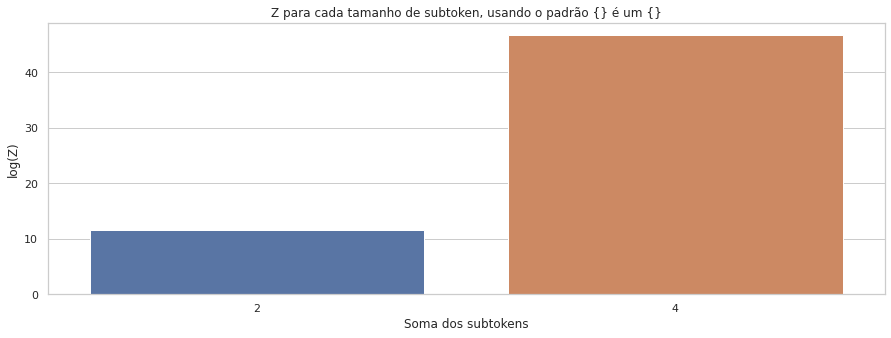

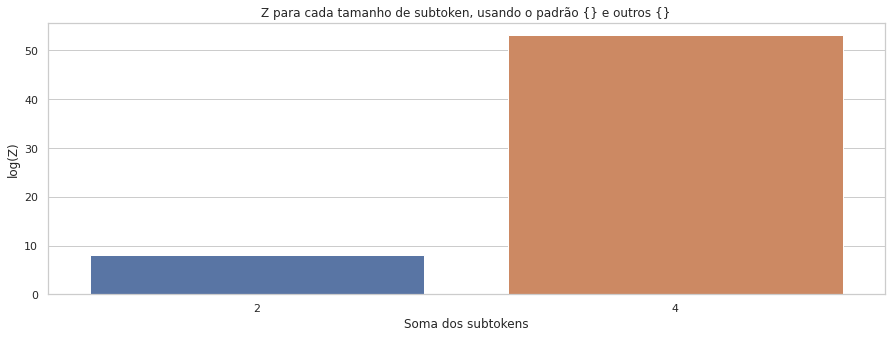

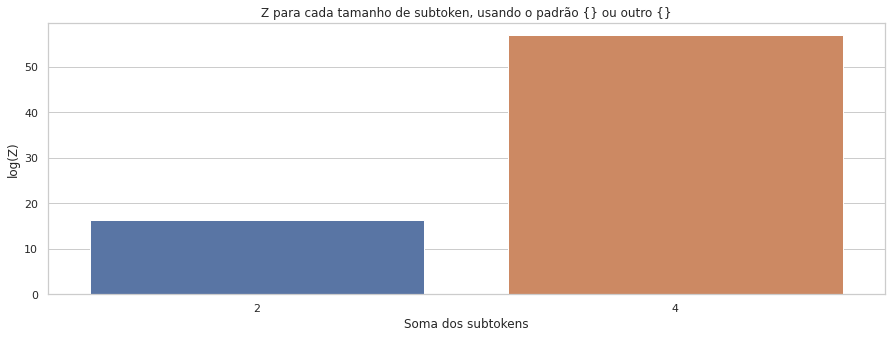

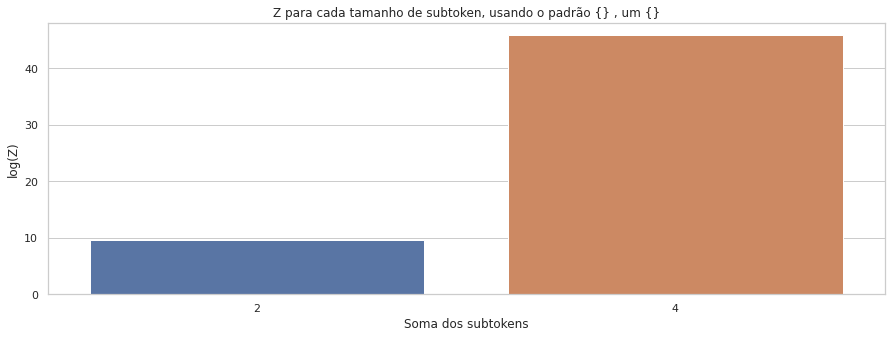

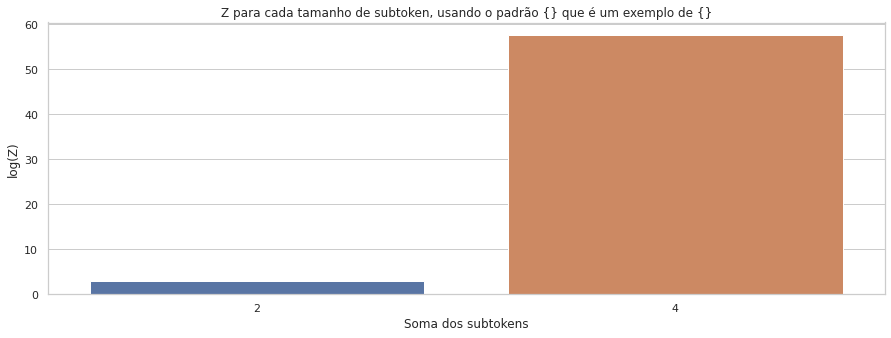

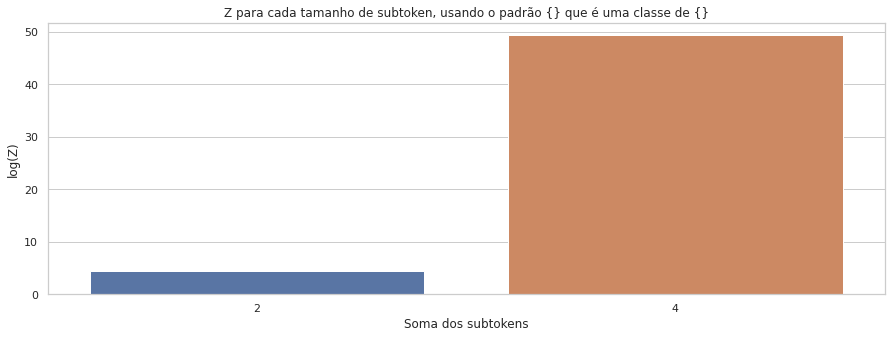

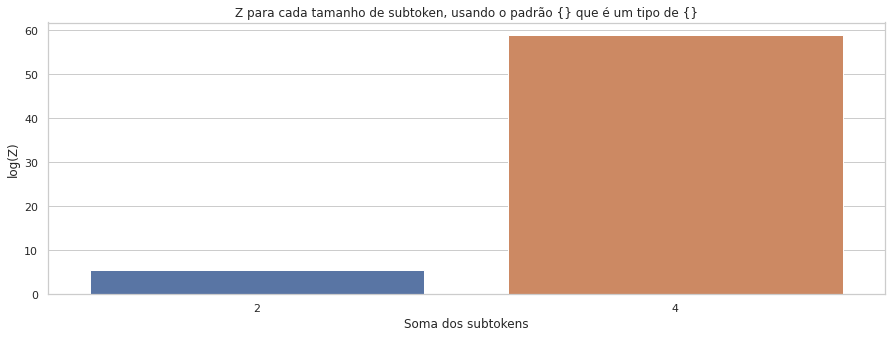

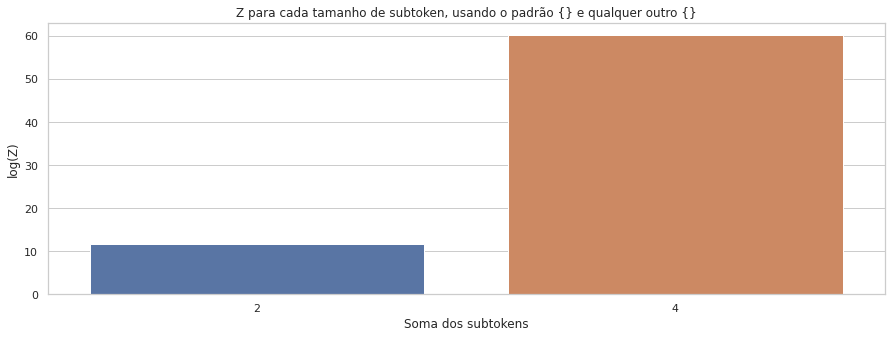

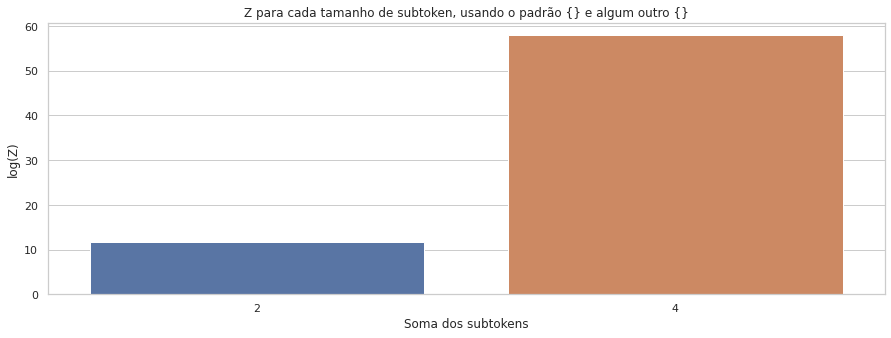

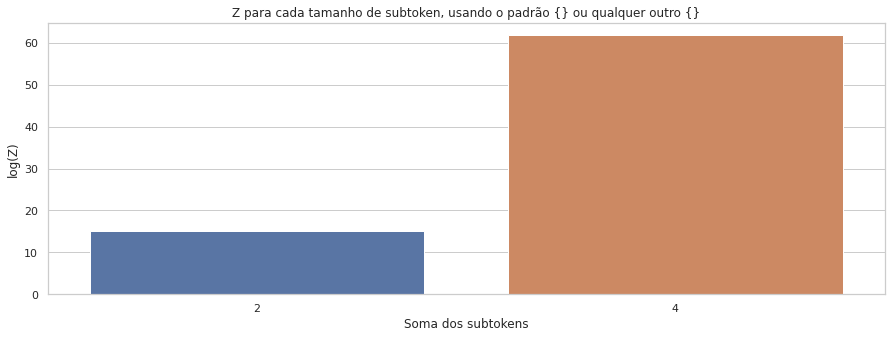

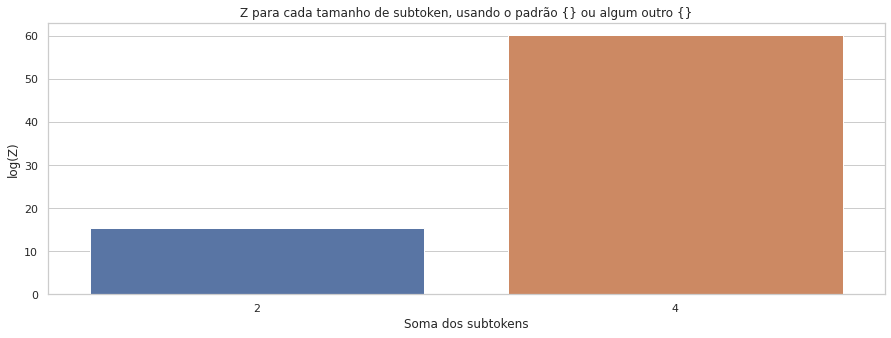

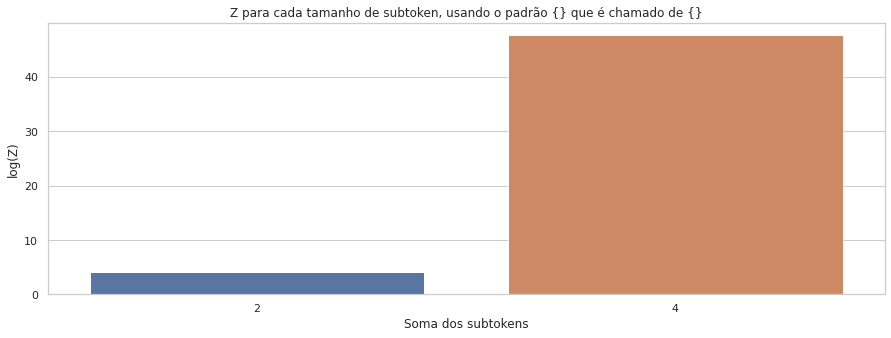

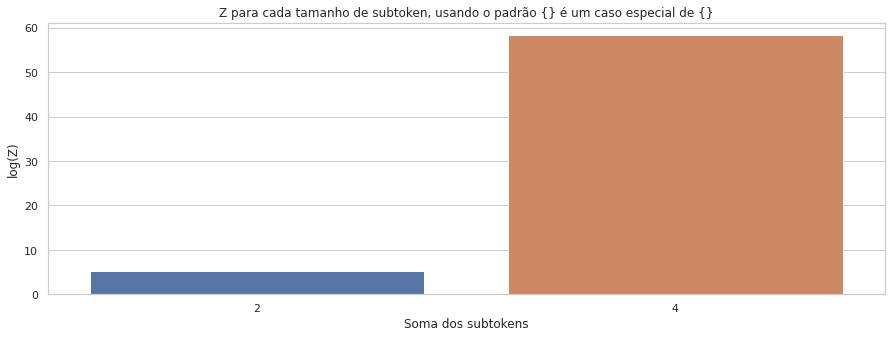

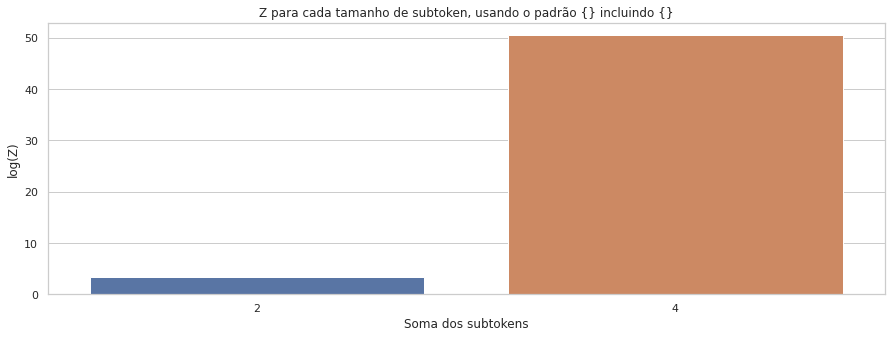

In [3]:
# figure
for p in pattern_unique:
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='len_total', y='log(Z)', ci='sd', data=df[df['pattern'] == p ])
    ax.set(xlabel="Soma dos subtokens")
    ax.set_title(f"Z para cada tamanho de subtoken, usando o padrão {p}")
    plt.show()

### Rank score para cada tamanho de subtoken e padrão.
- eixo X = Tamanho do subtoken
- eixo Y = Rank do par. Soma dos pares menos o Z do tamanho do par

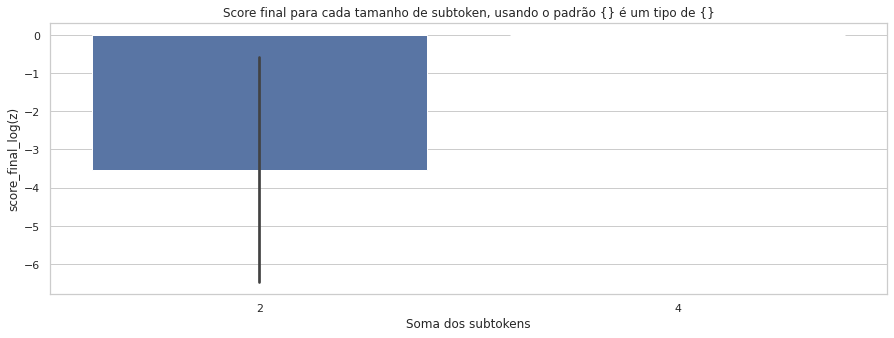

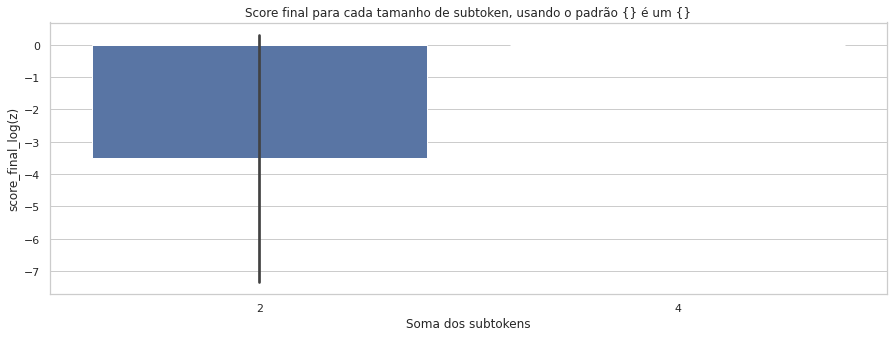

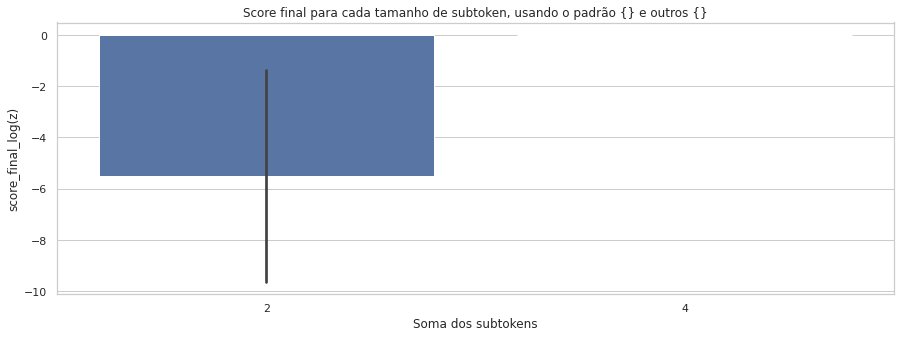

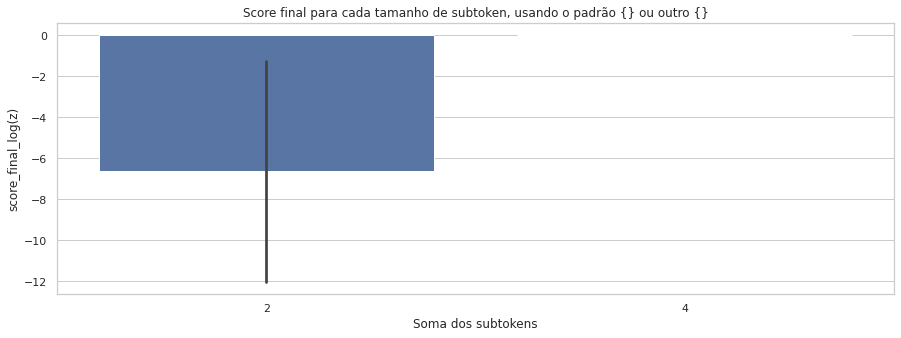

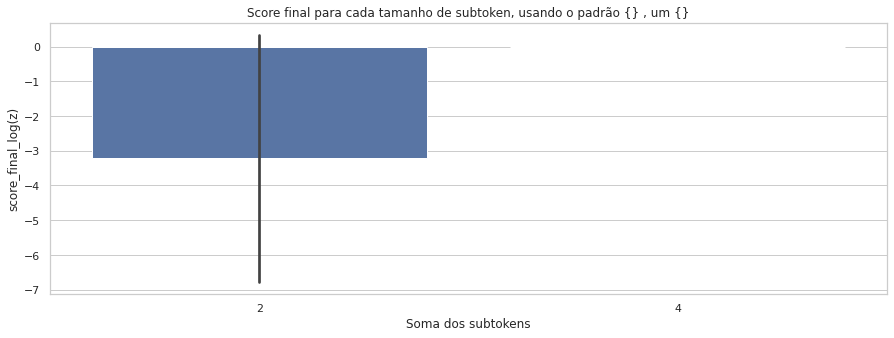

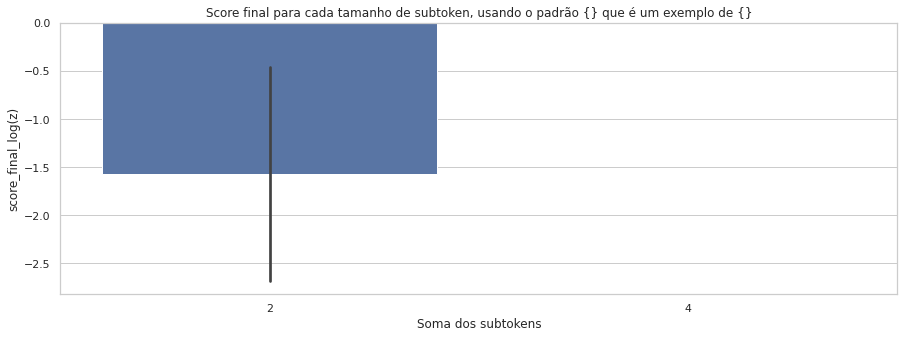

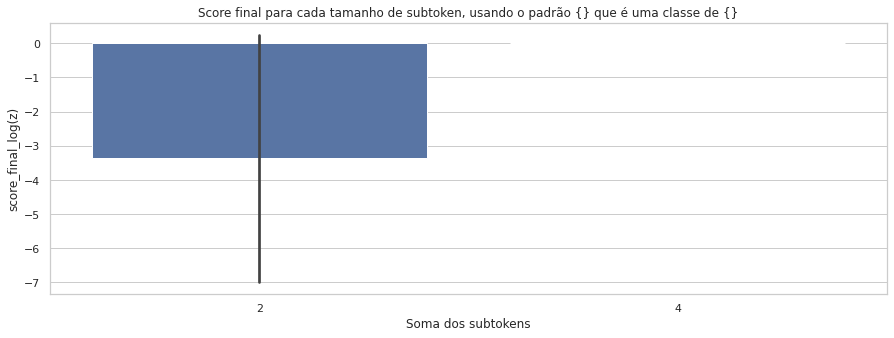

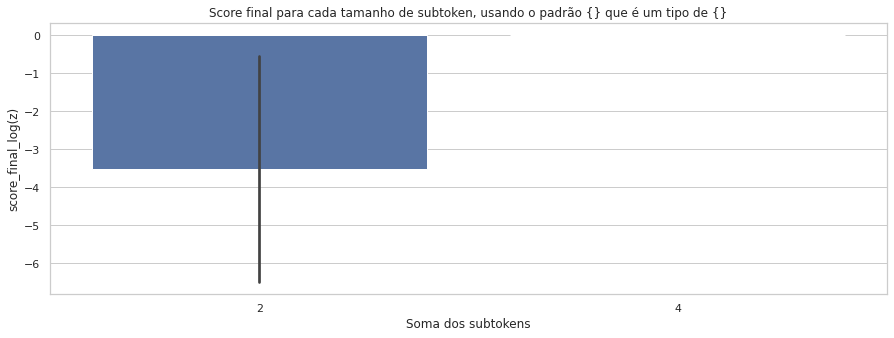

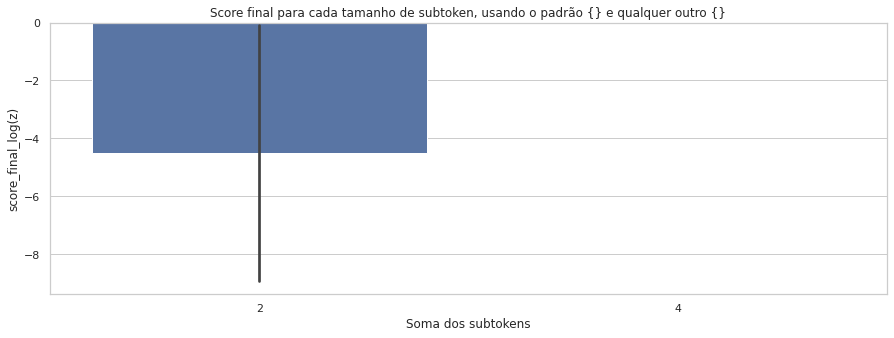

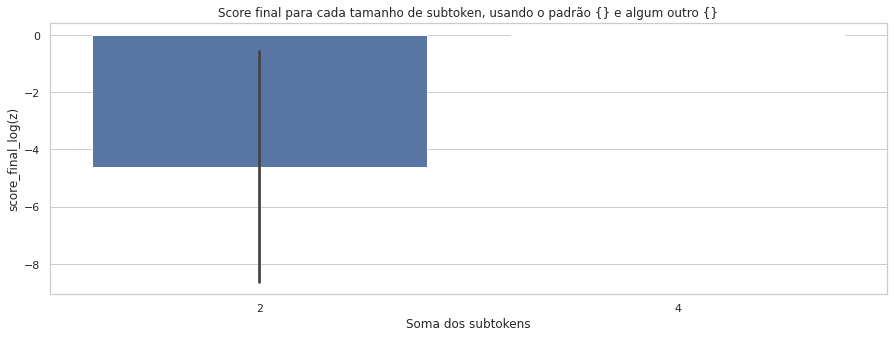

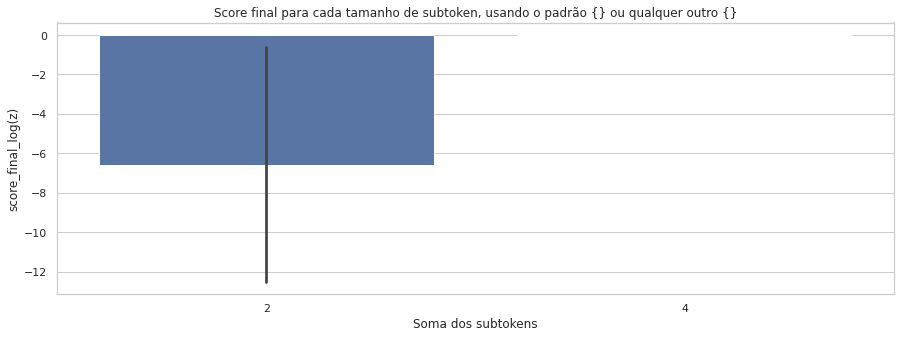

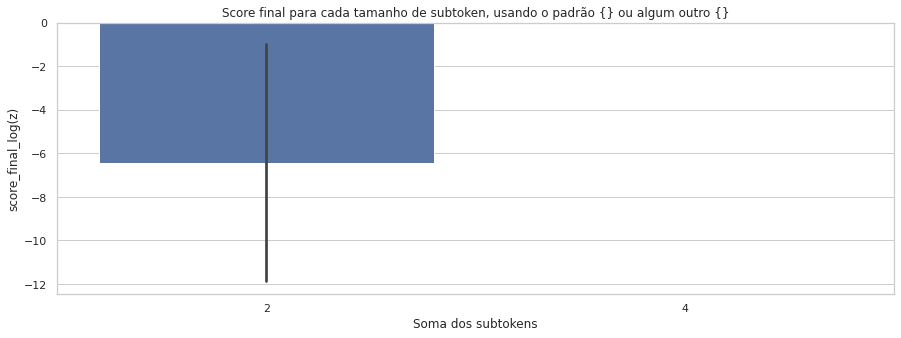

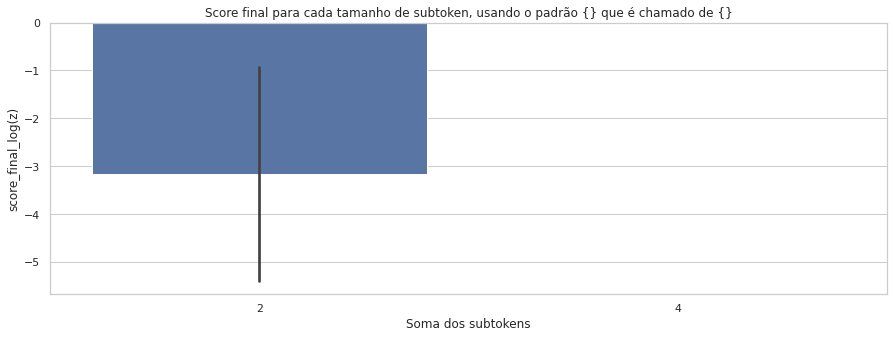

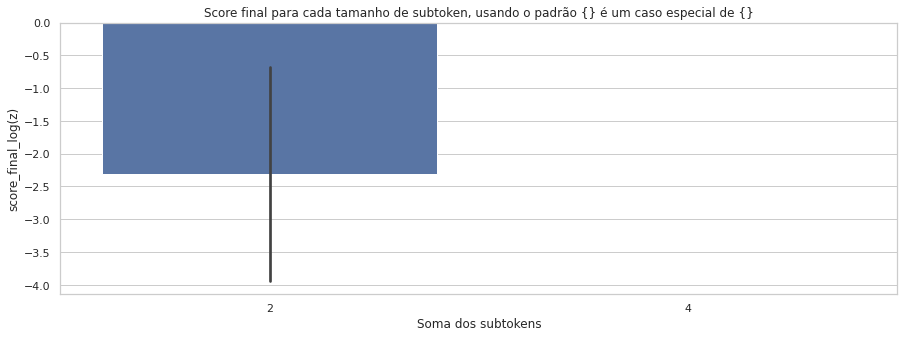

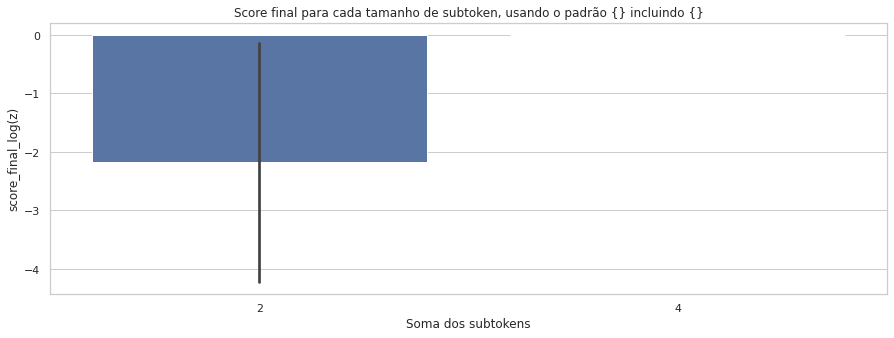

In [4]:
#score final soma_total - log(Z)

df['score_final_log(z)'] = df['bert_soma_total'] - df['log(Z)']
df['score_final_norm'] = df['bert_soma_total'] / df['sum_bert_by_tokensize']


for p in pattern_unique:
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='len_total', y='score_final_log(z)', ci='sd', data=df[df['pattern'] == p ])
    ax.set(xlabel="Soma dos subtokens")
    ax.set_title(f"Score final para cada tamanho de subtoken, usando o padrão {p}")
    plt.show()

### AP para cada pattern
- Existem 2 score final
 > Soma BERT - log(Z), sendo log(Z) o logsumexp das somas do BERT para um determinado tamanho de subtoken e padrão.

 > Soma BERT / Soma de todos os BERT, este ultimo usando somente os BERT de mesmo tamanho de subtoken e padrao.



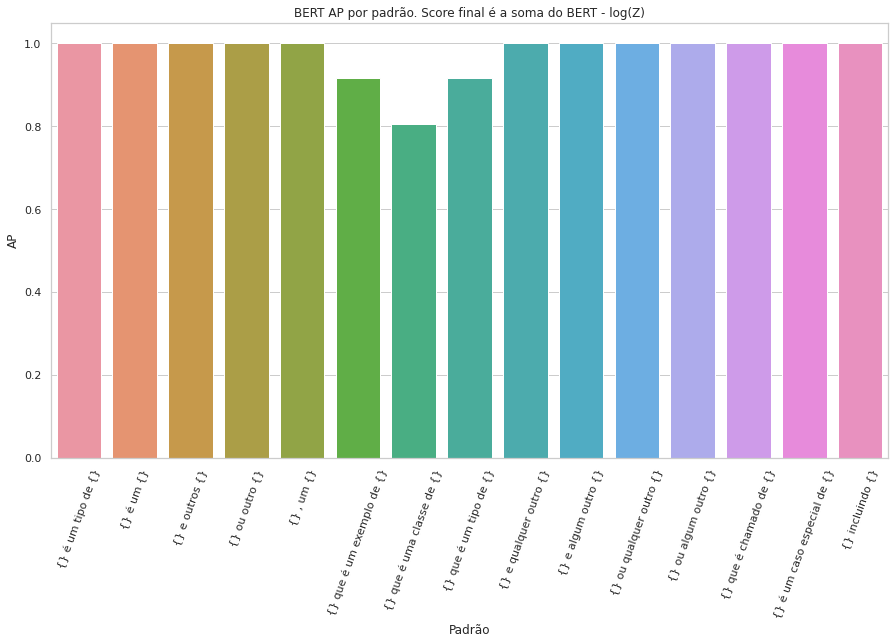

In [5]:
def filter_by_vocab(path_vocab, dict_data):
    wiki_name = path_vocab.split("/")[-2][9:]
    new_data = {}
    vocab = []
    for line in open(path_vocab):
        w, c = line.strip().split()
        vocab.append(w)
    vocab = set(vocab)

    for k, v in dict_data.items():
        hipo, hyper, _, _ = k.strip().split()
        if hipo in vocab and hyper in vocab:
            new_data[k] = v.copy()
    return wiki_name, new_data




# ap usando bert_sum - log(z)
df_view = df[df['pattern'] == pattern_unique[0]]
ap_by_pattern = {}

count = 0
for p in pattern_unique:
    df_iter = df[df['pattern'] == p]
    df_iter = df_iter.sort_values(by='score_final_log(z)', ascending=False)
    prec_list = []
    hyper_num = 0
    total_pair = 0
    for row in df_iter.itertuples():
        total_pair += 1
        if row.fonte == 'hyper':
            hyper_num += 1
            prec_list.append(hyper_num / float(total_pair))

    ap_by_pattern[p] = np.mean(prec_list)

df_ap = pd.DataFrame(data={'padrao': pattern_unique, 'AP': list(ap_by_pattern.values())})
plt.figure(figsize=(15,8))
ax = sns.barplot(data=df_ap, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT - log(Z)")
plt.xticks(rotation=70)
plt.show()

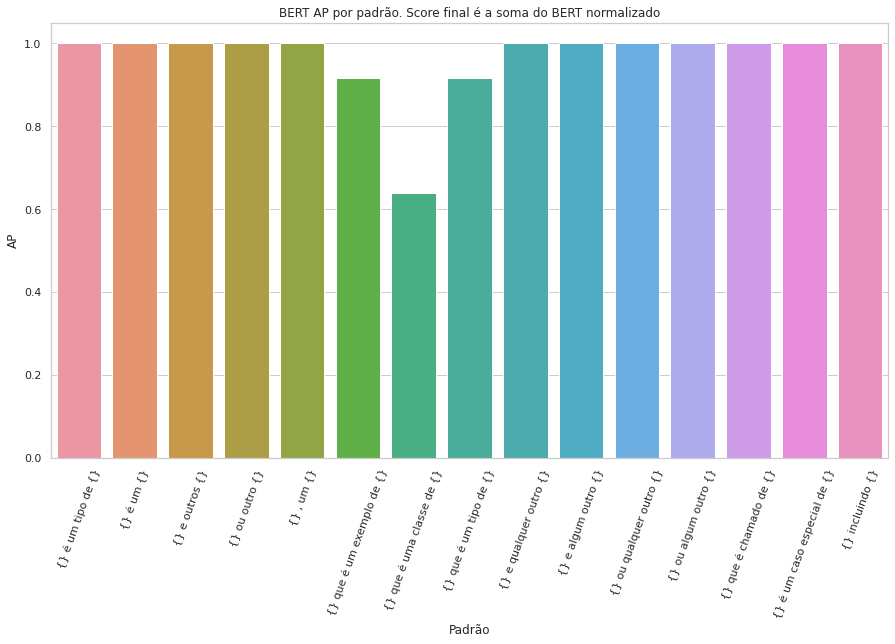

In [6]:
# ap usando bert_sum / sum(bert_sum_tokensize)
df_view = df[df['pattern'] == pattern_unique[0]]
ap_by_pattern = {}

count = 0
for p in pattern_unique:
    df_iter = df[df['pattern'] == p]
    df_iter = df_iter.sort_values(by='score_final_norm', ascending=False)
    prec_list = []
    hyper_num = 0
    total_pair = 0
    for row in df_iter.itertuples():
        total_pair += 1
        if row.fonte == 'hyper':
            hyper_num += 1
            prec_list.append(hyper_num / float(total_pair))

    ap_by_pattern[p] = np.mean(prec_list)

df_ap = pd.DataFrame(data={'padrao': pattern_unique, 'AP': list(ap_by_pattern.values())})
plt.figure(figsize=(15,8))
ax = sns.barplot(data=df_ap, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT normalizado")

plt.xticks(rotation=70)
plt.show()

In [7]:
for size in len_total_unique:
    print(size, df_rate[size].sum())


4 1
2 3
